In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA

In [2]:
from soap import *

In [3]:
_, structure, species = read_cif("CIF_files/DB0-m1_o14_smb_repeat.cif")

In [4]:
soap_out, soap = S(structure = structure, species = species)

In [5]:
soap_out.shape

(213, 20)

In [6]:
N_env, N_feat = soap_out.shape

In [46]:
# 1) Build the N_env × N_env kernel among environments.  
#    For example, use an RBF kernel with some gamma > 0.
def rbf_kernel(u, v, gamma=1e-3):
    diff = u - v
    return np.exp(-gamma * (diff @ diff))

K = np.zeros((N_feat, N_feat))
for i in range(N_feat):
    for j in range(N_feat):
        K[i, j] = rbf_kernel(soap_out[:,i], soap_out[:,j], gamma=1e-3)

eigvals, eigvecs = np.linalg.eigh(K)
alpha = eigvecs[:, -1]       # shape = (N_env,)
# (Optionally, you can normalize alpha so that sum(alpha^2)=1 or so that sum(alpha)=1, etc.)
alpha = alpha / np.linalg.norm(alpha)

# # --- 3) Form the weighted‐sum row d = alpha^T @ soap_out ---
# d = alpha.reshape(1, N_feat) @ soap_out   # shape = (1, N_feat)

# print("collapsed descriptor shape:", d.shape)

In [47]:
alpha.shape

(20,)

In [48]:
N_feat

20

In [49]:
alpha.shape

(20,)

In [52]:
soap_out.shape

(213, 20)

In [50]:
d = (soap_out * alpha).mean(axis=0, keepdims=True)

In [51]:
d.shape

(1, 20)

In [31]:
d[0]

array([ 1.98887248e-02,  1.42402717e-02,  2.00565801e-03, -1.38706216e-02,
        4.36124519e-02, -7.17911631e-04,  2.67829005e-03, -3.90048751e-04,
        2.08858708e-32,  8.33363883e-02,  8.30706535e-02, -4.17494182e-03,
        3.24709208e-02, -3.61391006e-03,  4.16059825e-02,  6.06245800e-03,
        1.00896216e-01,  7.87191977e-04,  7.62855528e-02,  2.17593092e-03])

In [35]:
si,_ = S(structure = structure, species = species, average = "inner")

In [36]:
si

array([ 1.52091564e+00,  4.50189564e-05,  4.16378818e+00, -2.95287154e-05,
        1.03914068e+00,  2.32330997e-06,  2.98309005e-01, -1.78135509e-05,
        1.13991411e+01,  4.20726344e-05,  2.84484003e+00, -2.26701741e-05,
        8.16676138e-01,  1.01262552e-05,  7.09975838e-01,  2.98115188e-05,
        2.03814738e-01, -9.46465465e-06,  5.85096637e-02,  1.71519504e-05])

In [38]:
so,_ = S(structure = structure, species = species, average = "outer")

In [39]:
so

array([ 2.77902631e+00,  5.32198372e-02,  4.11588378e+00, -5.19847926e-02,
        1.63876232e-01, -2.68026443e-03,  9.99165625e-03, -1.45617068e-03,
        1.54767122e+01,  3.17557746e-01,  1.59166562e+00, -1.56041520e-02,
        1.21731496e-01, -1.35054514e-02,  1.99147215e+00,  2.26188261e-02,
        4.92624250e-01,  2.93805103e-03,  4.62426975e-01,  8.11873260e-03])

In [40]:
import numpy as np
import matplotlib.pyplot as plt

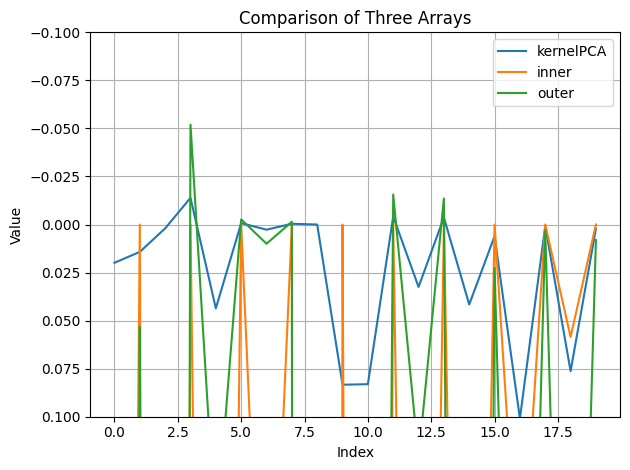

In [43]:
plt.plot(np.arange(20), d[0], label='kernelPCA')
plt.plot(np.arange(20), si, label='inner')
plt.plot(np.arange(20), so, label='outer')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Three Arrays')
plt.legend()
plt.ylim(0.1,-0.1)
plt.grid()
plt.tight_layout()
plt.show()

# ML

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.neural_network import MLPRegressor


In [ ]:
# Read feature descriptors
X = pd.read_csv('TrkernelPCA_soap_mofs.csv')

# Read labels
y = pd.read_csv('id_labels.csv')


In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
X['filename'] = X['filename'].str.replace('.cif', ' ', regex=False)

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
X.set_index('filename', inplace = True)

In [ ]:
y.set_index('id', inplace = True)

In [ ]:
X.sort_index(inplace=True)

In [ ]:
y.sort_index(inplace=True)

In [ ]:
print("Are they exactly equal?", (X.index == y.index).all())

In [ ]:
X

In [ ]:
for i in range(len(X.columns)):
    print(i, X.columns[i])

In [ ]:
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X

In [ ]:
# Step 1: Scale X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 3: Train linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Predict
y_pred = model.predict(X_test)

# Step 5: Evaluate
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)



In [ ]:
# Evaluate
print("Random Forest RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

In [ ]:
# Make a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)

# Plot a diagonal reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Labels
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (Random Forest)')
plt.grid(True)
plt.show()

In [ ]:
# 1. Get feature importances
importances = rf.feature_importances_

# 2. Map them to feature names
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# 3. Sort them descending
feature_importances = feature_importances.sort_values(ascending=False)

# 4. Plot the top N features
top_n = 20  # you can change to top 10, 20, etc.

plt.figure(figsize=(10, 6))
feature_importances[:top_n].plot(kind='barh')
plt.gca().invert_yaxis()  # Highest importance at top
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.grid(True)
plt.show()

In [ ]:
from pycaret.regression import *

In [ ]:
y

In [ ]:
data = pd.concat([X, y], axis = 1)

In [ ]:
data

In [ ]:
data.columns

In [ ]:
exp1 = setup(data, target='label', session_id=123)

In [ ]:
best_model = compare_models()

In [29]:
tuned_model_et = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.5343,18.3490,4.2836,0.7335,0.4700,1.3075
1,3.5922,20.0390,4.4765,0.6784,0.4375,0.5162
2,3.5644,18.6220,4.3153,0.7254,0.4683,0.6159
3,3.8298,20.1107,4.4845,0.6496,0.5053,0.7195
4,3.5321,18.7298,4.3278,0.6318,0.4977,0.6828
5,3.4995,19.3535,4.3993,0.6520,0.4773,0.6038
6,3.8585,20.6650,4.5459,0.6433,0.4526,0.5535
7,3.9042,22.7469,4.7694,0.6441,0.4966,0.6482
8,3.7955,21.0370,4.5866,0.6789,0.4944,0.6665


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
tuned_model_rf = tune_model(create_model('rf'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0999,15.9708,3.9964,0.7681,0.4323,1.1246
1,2.8943,14.4239,3.7979,0.7685,0.3732,0.3972
2,3.0284,14.7340,3.8385,0.7828,0.4119,0.4941
3,3.2801,16.5426,4.0673,0.7118,0.4563,0.6105
4,3.0029,15.9591,3.9949,0.6863,0.4548,0.5612
5,2.8216,13.3719,3.6568,0.7596,0.4192,0.4926
6,3.3271,17.7651,4.2149,0.6933,0.4196,0.4515
7,3.2215,17.0039,4.1236,0.7340,0.4442,0.5461
8,3.1477,16.3419,4.0425,0.7506,0.4367,0.5292


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.3451,16.9408,4.1159,0.7540,0.4408,1.0795
1,3.2650,17.0359,4.1275,0.7266,0.4030,0.4509
2,3.2213,15.9140,3.9892,0.7654,0.4320,0.5378
3,3.5531,18.4848,4.2994,0.6780,0.4792,0.6567
4,3.3379,18.1670,4.2623,0.6428,0.4826,0.6245
5,3.1314,15.5981,3.9494,0.7195,0.4456,0.5406
6,3.6272,19.2517,4.3877,0.6677,0.4360,0.5064
7,3.4877,19.1978,4.3815,0.6997,0.4616,0.5710
8,3.4752,18.8366,4.3401,0.7125,0.4635,0.5888


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [31]:
tuned_model_xg = tune_model(create_model('xgboost'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.1947,17.1262,4.1384,0.7513,0.4338,0.9580
1,2.7889,14.8557,3.8543,0.7616,0.3704,0.3494
2,3.0203,17.2838,4.1574,0.7452,0.4318,0.4934
3,3.3165,18.5206,4.3036,0.6773,0.4791,0.5848
4,3.2490,18.5421,4.3061,0.6355,0.4777,0.5459
5,2.9294,13.6559,3.6954,0.7545,0.4071,0.4581
6,3.4868,20.8753,4.5690,0.6396,0.4622,0.4964
7,3.2382,17.5682,4.1914,0.7252,0.4643,0.5659
8,3.0927,16.6214,4.0769,0.7463,0.4330,0.4875


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.1638,16.8014,4.0990,0.7560,0.4343,1.1905
1,2.7979,15.0510,3.8796,0.7585,0.3969,0.3580
2,2.8828,13.7735,3.7113,0.7969,0.3988,0.4564
3,3.2828,17.7192,4.2094,0.6913,0.4809,0.6215
4,3.0259,16.1907,4.0238,0.6817,0.4506,0.5485
5,2.8639,12.7721,3.5738,0.7703,0.3993,0.4620
6,3.3132,18.7841,4.3341,0.6757,0.4366,0.4673
7,3.0754,17.0027,4.1234,0.7340,0.4462,0.5284
8,3.0167,15.3759,3.9212,0.7653,0.4296,0.4816


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
tuned_model_lgbm = tune_model(create_model('lightgbm'))

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:23:06
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Processing:   0%|          | 0/4 [00:00<?, ?it/s]